<a href="https://www.kaggle.com/code/ammiyacine/mobile-churn-ml-model-92-accuracy?scriptVersionId=126375148" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Project Overview

## Objective

The objective of this project is to analyze a public dataset of customers from a telecom company and predict whether a customer will switch to another company, thereby increasing profitability. 

## Dataset Description

- This project utilizes a public dataset of 66,469 customers from an anonymous telecommunications company.
- The goal of the project is to predict customer churn and increase profitability for the company.
- Data preprocessing and cleaning techniques were used on 66 features before moving to the modelling phase.

# Envirenment Setup

In [1]:
#General
import pandas as pd
import numpy as np
import sklearn
import shap 
#Preprocessing
from itertools import cycle
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from scipy import stats, interp
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.feature_selection import RFECV, RFE
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import SMOTE
#Models
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, label_binarize
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.cluster import KMeans 
#Model_Evaluation
import optuna
from sklearn.metrics import roc_curve, auc, make_scorer, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, plot_confusion_matrix, classification_report, average_precision_score
from sklearn.metrics import roc_auc_score, precision_recall_curve
#Visualization
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
#Setting_Parameters
import warnings
warnings.filterwarnings('ignore')
sns.set()
style.use('ggplot')
pd.set_option("display.max_rows", 100)
%matplotlib inline 
plt.rcParams["figure.figsize"] = (12, 8)
cmap = LinearSegmentedColormap.from_list("", ['#FFFFFF',"#FFF5BD","#FF4646",'#E41A1C',"#960018"])

In [2]:
!pip install xlrd
!pip install openpyxl


     |████████████████████████████████| 96 kB 2.6 MB/s 
     |████████████████████████████████| 249 kB 8.0 MB/s 


In [3]:
def reduce_mem_usage(train_data):
    """ iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.
    """
    start_mem = train_data.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in train_data.columns:
        col_type = train_data[col].dtype

        if col_type != object:
            c_min = train_data[col].min()
            c_max = train_data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    train_data[col] = train_data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    train_data[col] = train_data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    train_data[col] = train_data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    train_data[col] = train_data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    train_data[col] = train_data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    train_data[col] = train_data[col].astype(np.float32)
                else:
                    train_data[col] = train_data[col].astype(np.float64)
        else:
            train_data[col] = train_data[col].astype('category')

    end_mem = train_data.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return train_data


# Preparation & Cleanup

In [4]:
%%time
df = pd.read_excel('/kaggle/input/mobilechurndataxlsx/mobile-churn-data.xlsx')
df.head()

CPU times: user 1min 31s, sys: 323 ms, total: 1min 32s
Wall time: 1min 33s


,year,month,user_account_id,user_lifetime,user_intake,user_no_outgoing_activity_in_days,user_account_balance_last,user_spendings,user_has_outgoing_calls,user_has_outgoing_sms,...,last_100_calls_outgoing_duration,last_100_calls_outgoing_to_onnet_duration,last_100_calls_outgoing_to_offnet_duration,last_100_calls_outgoing_to_abroad_duration,last_100_sms_outgoing_count,last_100_sms_outgoing_to_onnet_count,last_100_sms_outgoing_to_offnet_count,last_100_sms_outgoing_to_abroad_count,last_100_gprs_usage,churn
0,2013,6,13,1000,0,1,0.05,0.00,1,1,...,75.27,0.00,63.43,0.00,210,1,84,0,0.0,0
1,2013,6,14,1000,0,25,28.31,3.45,1,0,...,13.38,11.18,2.00,11.18,0,0,0,0,0.0,0
2,2013,6,18,1005,0,8,15.62,1.97,1,0,...,30.00,0.00,0.00,10.45,0,0,0,0,0.0,0
3,2013,6,27,1013,0,11,5.62,0.00,1,0,...,0.00,0.00,0.00,0.00,0,0,0,0,0.0,1
4,2013,6,32,1032,0,2,5.86,0.15,1,0,...,2.58,0.00,1.00,0.00,0,0,0,0,0.0,0


In [5]:
print('Feature names: \n',df.columns)

Feature names: 
 Index(['year', 'month', 'user_account_id', 'user_lifetime', 'user_intake',
       'user_no_outgoing_activity_in_days', 'user_account_balance_last',
       'user_spendings', 'user_has_outgoing_calls', 'user_has_outgoing_sms',
       'user_use_gprs', 'user_does_reload', 'reloads_inactive_days',
       'reloads_count', 'reloads_sum', 'calls_outgoing_count',
       'calls_outgoing_spendings', 'calls_outgoing_duration',
       'calls_outgoing_spendings_max', 'calls_outgoing_duration_max',
       'calls_outgoing_inactive_days', 'calls_outgoing_to_onnet_count',
       'calls_outgoing_to_onnet_spendings', 'calls_outgoing_to_onnet_duration',
       'calls_outgoing_to_onnet_inactive_days',
       'calls_outgoing_to_offnet_count', 'calls_outgoing_to_offnet_spendings',
       'calls_outgoing_to_offnet_duration',
       'calls_outgoing_to_offnet_inactive_days',
       'calls_outgoing_to_abroad_count', 'calls_outgoing_to_abroad_spendings',
       'calls_outgoing_to_abroad_duration',

In [6]:
df.drop(['year', 'user_account_id'], axis=1, inplace=True)

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
month,66469.0,6.256721,0.662637,6.000,6.00,6.00,6.00,8.00
user_lifetime,66469.0,4006.037867,6058.350935,0.000,457.00,1216.00,1985.00,15947.00
user_intake,66469.0,0.040365,0.196815,0.000,0.00,0.00,0.00,1.00
user_no_outgoing_activity_in_days,66469.0,63.975718,264.006882,0.000,1.00,2.00,8.00,1307.00
user_account_balance_last,66469.0,9.645420,18.473371,0.000,0.04,5.27,12.92,1775.71
user_spendings,66469.0,6.845812,14.512993,-30.060,0.00,2.28,8.11,1236.47
user_has_outgoing_calls,66469.0,0.804450,0.396626,0.000,1.00,1.00,1.00,1.00
user_has_outgoing_sms,66469.0,0.603229,0.489232,0.000,0.00,1.00,1.00,1.00
user_use_gprs,66469.0,0.045074,0.207467,0.000,0.00,0.00,0.00,1.00
user_does_reload,66469.0,0.560246,0.496361,0.000,0.00,1.00,1.00,1.00


In [8]:
reduce_mem_usage(df)

Memory usage of dataframe is 32.46 MB
Memory usage after optimization is: 7.61 MB
Decreased by 76.6%


,month,user_lifetime,user_intake,user_no_outgoing_activity_in_days,user_account_balance_last,user_spendings,user_has_outgoing_calls,user_has_outgoing_sms,user_use_gprs,user_does_reload,...,last_100_calls_outgoing_duration,last_100_calls_outgoing_to_onnet_duration,last_100_calls_outgoing_to_offnet_duration,last_100_calls_outgoing_to_abroad_duration,last_100_sms_outgoing_count,last_100_sms_outgoing_to_onnet_count,last_100_sms_outgoing_to_offnet_count,last_100_sms_outgoing_to_abroad_count,last_100_gprs_usage,churn
0,6,1000,0,1,0.049988,0.000000,1,1,0,0,...,75.250000,0.000000,63.4375,0.000000,210,1,84,0,0.0,0
1,6,1000,0,25,28.312500,3.449219,1,0,0,0,...,13.382812,11.179688,2.0000,11.179688,0,0,0,0,0.0,0
2,6,1005,0,8,15.617188,1.969727,1,0,0,0,...,30.000000,0.000000,0.0000,10.453125,0,0,0,0,0.0,0
3,6,1013,0,11,5.621094,0.000000,1,0,0,0,...,0.000000,0.000000,0.0000,0.000000,0,0,0,0,0.0,1
4,6,1032,0,2,5.859375,0.150024,1,0,0,1,...,2.580078,0.000000,1.0000,0.000000,0,0,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66464,8,15947,0,1,0.000000,0.000000,0,0,0,1,...,0.000000,0.000000,0.0000,0.000000,0,0,0,0,0.0,1
66465,8,15947,0,1,0.000000,0.000000,0,0,0,1,...,0.000000,0.000000,0.0000,0.000000,0,0,0,0,0.0,1
66466,8,15947,0,1,15.000000,0.000000,0,0,0,1,...,0.000000,0.000000,0.0000,0.000000,0,0,0,0,0.0,0
66467,8,15947,0,1,0.000000,0.000000,0,0,0,1,...,0.000000,0.000000,0.0000,0.000000,0,0,0,0,0.0,0


# Data Preprocessing

### Checking for null values 

In [9]:
null = df.isnull().sum().sum()
print('-'*40)
print('Null values check')
print('-'*40)
print('There is {} null values in the Data Frame'.format(null))

----------------------------------------
Null values check
----------------------------------------
There is 0 null values in the Data Frame


### Correlation Inspection 

In [10]:
def correlation_heatmap(df, fig=20, annot=False, filtering=None,sort=True,name='Title', title='Pearson Correlation of Features'):
    """
    Create a correlation matrix with respect to the most correlated variables, and the ability 
    to filter the correlation matrix by pourcentage between 0-1"""
    if sort == True:
        cols1=[]
        cols2=[]
        value=[]
        matrix = df.corr()
        for i in range(len(matrix.columns)):
            for j in range(i):
                cols1.append(matrix.columns[i])
                cols2.append(matrix.columns[j])
                value.append(matrix.iloc[i,j])
        new_df = pd.DataFrame({'column_name_1': cols1, 'column_name_2': cols2, 'corr':value})
        new_df.sort_values('corr',ascending=False, inplace=True)
    
        if filtering != None:
            new_df = new_df[(abs(new_df['corr']) >= filtering)]
    
        all_cols = []
        cols = []
        for index, row in new_df.iterrows():
            all_cols.append(row.column_name_1)
            all_cols.append(row.column_name_2)
        for col in all_cols:
            if col not in cols:
                cols.append(col)
        final = df[cols]
    else:
        final = df.copy()
    _ , ax = plt.subplots(figsize =(fig, fig))
    colormap = sns.diverging_palette(240, 10,n=9, as_cmap = True)
    
    _ = sns.heatmap(
        final.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=annot, 
        linewidths=0.1,
        vmin=-1, 
        vmax=1.0, 
        linecolor='white',
        annot_kws={'fontsize':8 }
    )
    
    plt.title(title, y=1.05, size=15)
    if name == 'title':
        name = str(tittle)
    plt.savefig(name+".png",transparent=True)
    

#### Correlation matrix of the data

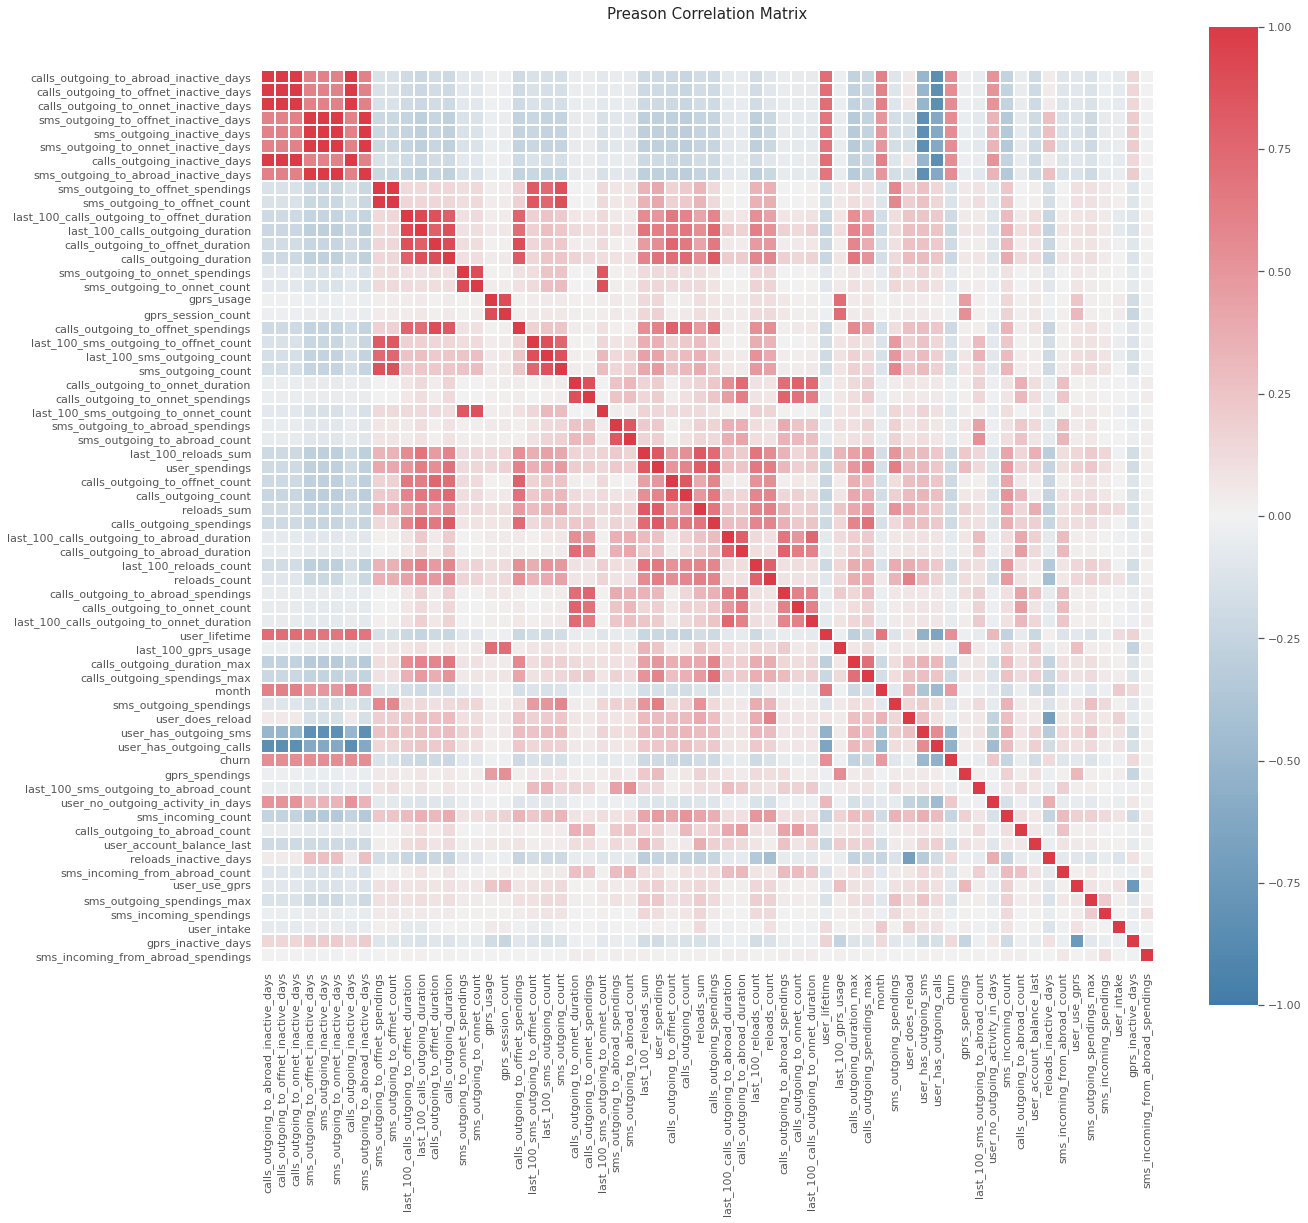

In [11]:
correlation_heatmap(df, sort=True, title='Preason Correlation Matrix', name='corr_all_feat')

* There are numerous columns with high correlation in the data.

#### Correlation matrix of filtered columns (85%) 


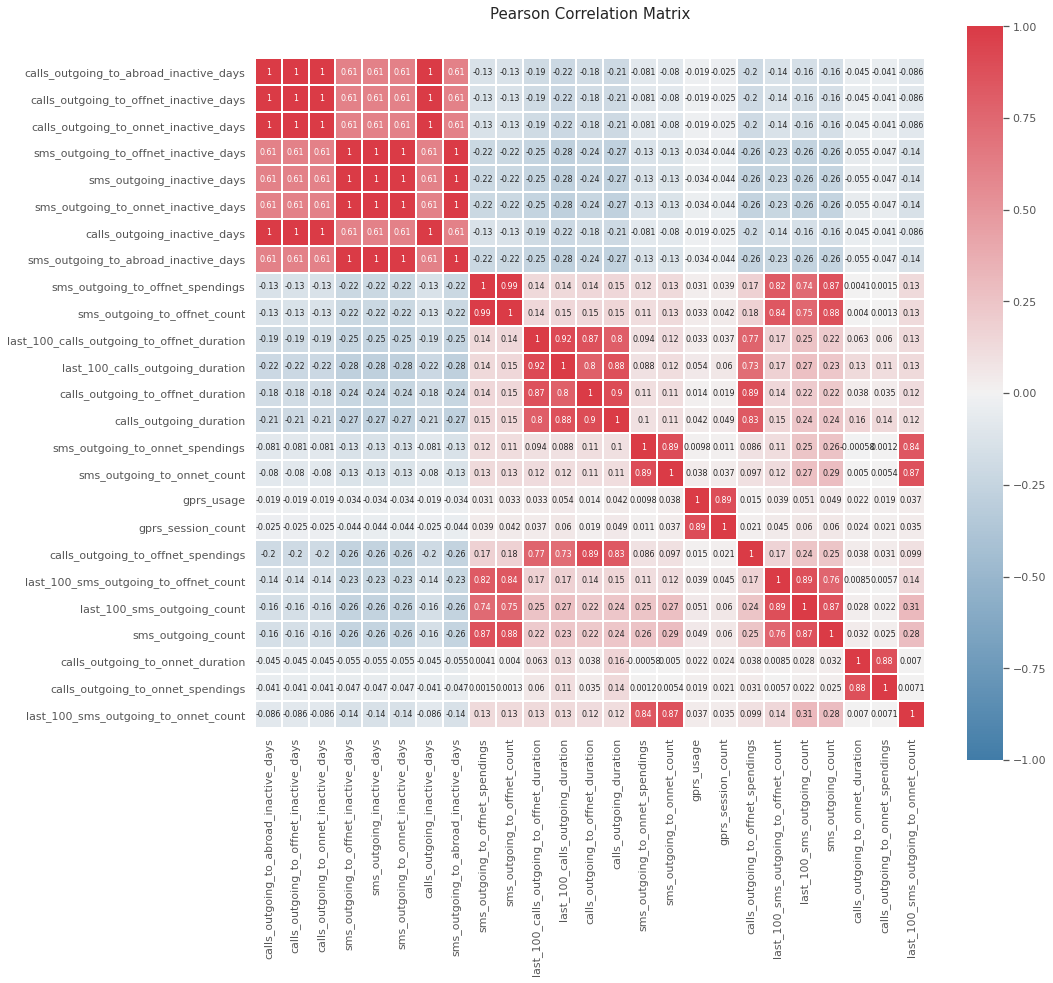

In [12]:
correlation_heatmap(df, fig=15,sort=True, name='corr_filtrd_feat', annot=True, filtering=0.85, title='Pearson Correlation Matrix')

* The correlation matrix of the dropped columns shows that every column has at least one or more columns in which the correlation exceeds 85%.

#### Correlation matrix after filtering

In [13]:
cols1=[]
cols2=[]
value=[]
matrix = df.corr()
for i in range(len(matrix.columns)):
    for j in range(i):
        cols1.append(matrix.columns[i])
        cols2.append(matrix.columns[j])
        value.append(matrix.iloc[i,j])
new_df = pd.DataFrame({'Feature Name 1': cols1, 'Feature Name 2': cols2, 'Correlation':value})
new_df.sort_values('Correlation',ascending=False, inplace=True)
new_df.reset_index(drop=True, inplace=True)
new_df = new_df[new_df['Correlation']>0.85]
new_df['Feature Name 1'].unique()

array(['calls_outgoing_to_abroad_inactive_days',
       'sms_outgoing_to_offnet_inactive_days',
       'calls_outgoing_to_onnet_inactive_days',
       'sms_outgoing_to_onnet_inactive_days',
       'sms_outgoing_to_abroad_inactive_days',
       'calls_outgoing_to_offnet_inactive_days',
       'sms_outgoing_to_offnet_spendings',
       'last_100_calls_outgoing_to_offnet_duration',
       'calls_outgoing_to_offnet_duration',
       'sms_outgoing_to_onnet_spendings', 'gprs_usage',
       'last_100_sms_outgoing_to_offnet_count',
       'last_100_calls_outgoing_duration', 'sms_outgoing_to_offnet_count',
       'calls_outgoing_to_onnet_duration', 'last_100_sms_outgoing_count',
       'last_100_sms_outgoing_to_onnet_count'], dtype=object)

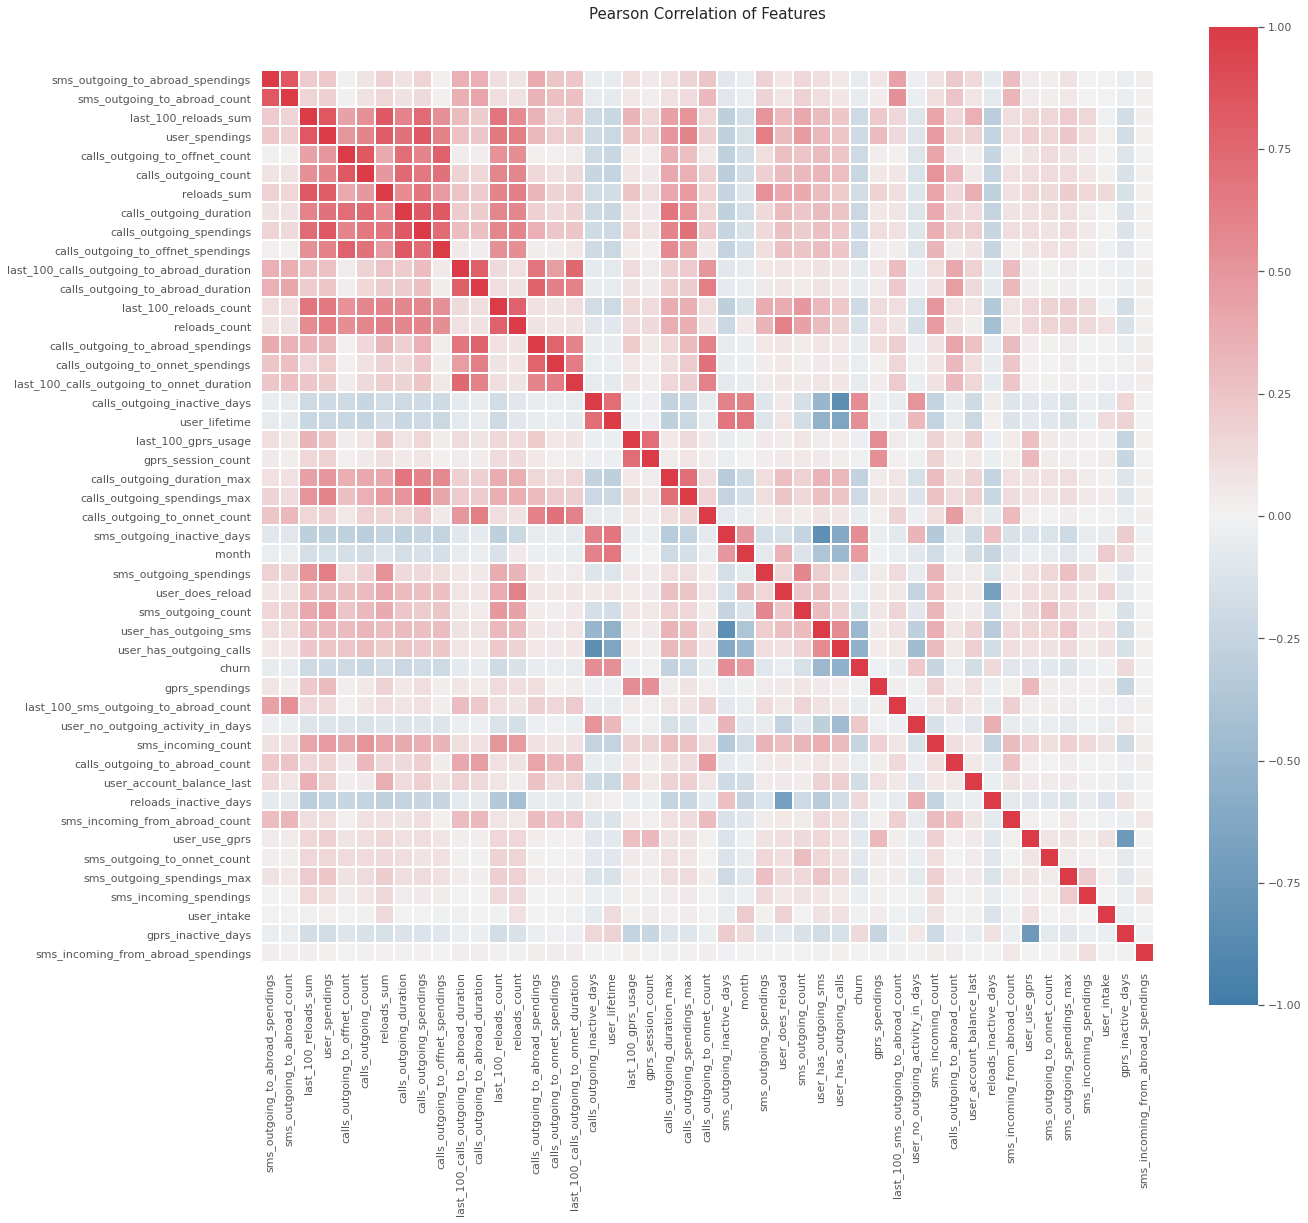

In [14]:
cols1=[]
matrix = df.corr()
for i in range(len(matrix.columns)):
    for j in range(i):
        if abs(matrix.iloc[i,j]) >= 0.85:
            cols1.append(matrix.columns[i])
dropped = df.drop(cols1, axis=1)
correlation_heatmap(dropped)

* After dropping the correlated columns, the new data seems to be clear of extreem correlations.

In [15]:
dropped.shape

(66469, 47)

# Exploratory Data Analysis

Due to the large number fo features (46), the visual exploratory data analysis will focus on the most prominent features.

In [16]:
dropped.churn = dropped.churn.map({0:'No', 1:'Yes'})
dropped.head()

,month,user_lifetime,user_intake,user_no_outgoing_activity_in_days,user_account_balance_last,user_spendings,user_has_outgoing_calls,user_has_outgoing_sms,user_use_gprs,user_does_reload,...,gprs_session_count,gprs_spendings,gprs_inactive_days,last_100_reloads_count,last_100_reloads_sum,last_100_calls_outgoing_to_onnet_duration,last_100_calls_outgoing_to_abroad_duration,last_100_sms_outgoing_to_abroad_count,last_100_gprs_usage,churn
0,6,1000,0,1,0.049988,0.000000,1,1,0,0,...,0,0.0,1276,4,12.007812,0.000000,0.000000,0,0.0,No
1,6,1000,0,25,28.312500,3.449219,1,0,0,0,...,0,0.0,1276,0,0.000000,11.179688,11.179688,0,0.0,No
2,6,1005,0,8,15.617188,1.969727,1,0,0,0,...,0,0.0,1276,0,0.000000,0.000000,10.453125,0,0.0,No
3,6,1013,0,11,5.621094,0.000000,1,0,0,0,...,0,0.0,1276,0,0.000000,0.000000,0.000000,0,0.0,Yes
4,6,1032,0,2,5.859375,0.150024,1,0,0,1,...,0,0.0,1276,1,6.000000,0.000000,0.000000,0,0.0,No


### Univariate

#### Analysing the user_no_outgoing_activity_in_days column

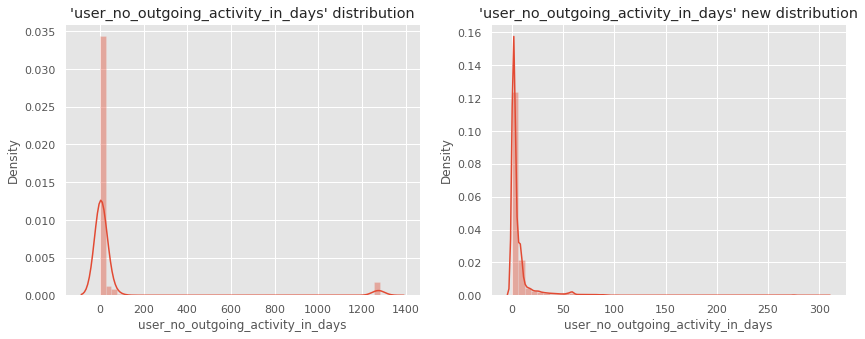

There were 3004 records dropped


In [17]:
f, axes = plt.subplots(1,2,figsize=(14,5))
sns.distplot(dropped.user_no_outgoing_activity_in_days, ax=axes[0])
axes[0].set_title("'user_no_outgoing_activity_in_days' distribution")
axes[1] = sns.distplot(dropped[dropped.user_no_outgoing_activity_in_days < 365]['user_no_outgoing_activity_in_days'])
axes[1].set_title("'user_no_outgoing_activity_in_days' new distribution")
plt.show()
f.savefig("user_no_outgoing_activity_in_days_DIST.png")
dropping = dropped[dropped.user_no_outgoing_activity_in_days > 365].shape[0]
print('There were {} records dropped'.format(dropping))
#dropped = dropped[dropped.user_no_outgoing_activity_in_days < 365]

* There are some clients with no activity for more than 3 years (1200 - 1400 days).
* Any Custommer who doesn't show any activity sign whatsoever for more than one year is considered as non active custommer, and therefore is excluded from the study. 

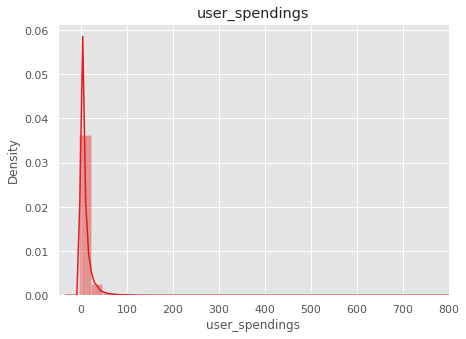

In [18]:
f, ax = plt.subplots(1,figsize=(7,5))
ax = sns.distplot(dropped.user_spendings, color="#e41a1c")
ax.set( xlim=(-50,800),title='user_spendings')
f.savefig("user_spendings_DIST_2.png")

* Most of the users spend from 0 to 100.

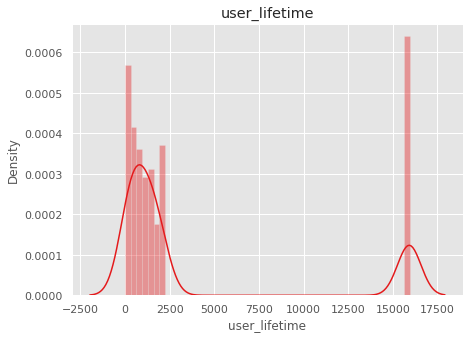

In [19]:
f, ax = plt.subplots(1,figsize=(7,5))
ax = sns.distplot(dropped.user_lifetime, color="#e41a1c")
ax.set(title='user_lifetime')
f.savefig("user_lifetime_DIST.png")
plt.show()

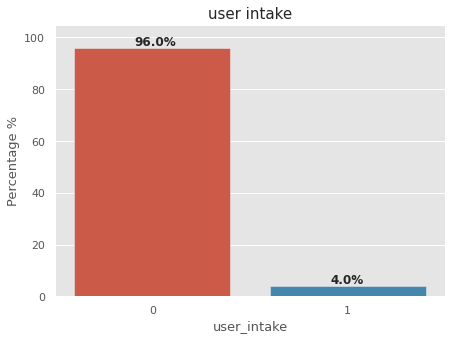

In [20]:
pourc = pd.DataFrame(dropped['user_intake']).value_counts()/len(dropped['user_intake'])*100
pourc = pd.DataFrame(pourc, columns=['pourcentage']).round().reset_index()
#pourc.churn = pourc.churn.map({0:'No', 1:'Yes'})
bar,ax = plt.subplots(1, figsize=(7,5))
ax = sns.barplot(data = pourc, x='user_intake', y='pourcentage', ci=None ,orient='v' )
ax.set(ylim=(0, 105))
ax.set_title("user intake", fontsize=15)
ax.set_xlabel ("user_intake",fontsize=13)
ax.set_ylabel ("Percentage %",fontsize=13)
for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width() / 2-0.09,rect.get_height()+0.9,"%.1f%%"% rect.get_height(), weight='bold',fontsize=12 )
bar.savefig('user_intake.png',transparent=True)

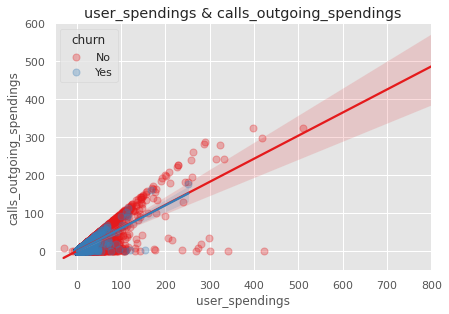

In [21]:
ax = sns.lmplot(x='user_spendings' , y='calls_outgoing_spendings', data=dropped , hue='churn', palette='Set1', height=4, aspect=1.5,legend_out=False,scatter_kws={"s": 50, "alpha":.3} )
ax.set(xlim=(-50, 800), ylim=(-50,600), title='user_spendings & calls_outgoing_spendings')
plt.show()
ax.savefig("user_spendings_VS_calls_outgoing_spendings.png",transparent=True)

* There is a positive correlation between user_spendings and calls_outgoing_spendings, which suggests that outgoing calls are one of the main services that drives the spending habits of the custommers.
* The more the user spends the less probable that he will churn and vice-versa.

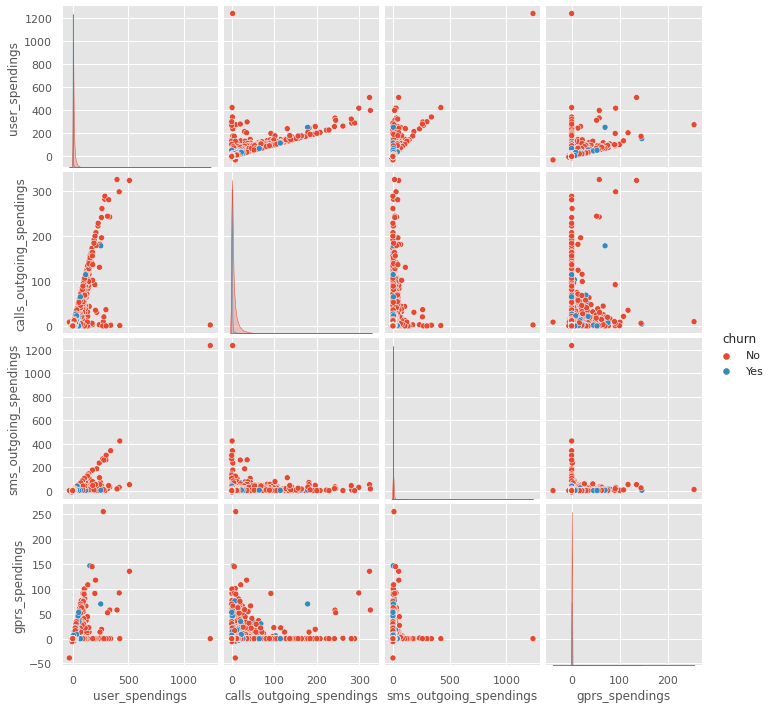

In [22]:
spending = dropped[['user_spendings', 'calls_outgoing_spendings', 'sms_outgoing_spendings','gprs_spendings', 'churn']]
sns.pairplot(spending, hue='churn', size=2.5)

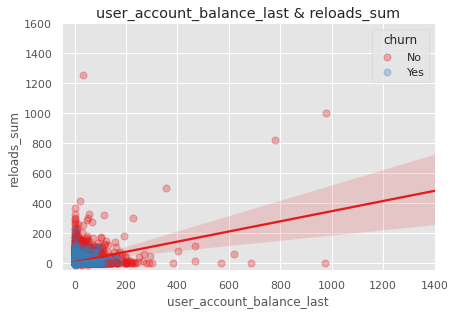

In [23]:
ax = sns.lmplot(x='user_account_balance_last' , y='reloads_sum', data=dropped , hue='churn', palette='Set1', height=4, aspect=1.5,legend_out=False,scatter_kws={"s": 50, "alpha":.3} )
ax.set(xlim=(-50, 1400), ylim=(-50,1600), title='user_account_balance_last & reloads_sum')
plt.show()
ax.savefig("user_account_balance_last_VS_reloads_sum.png")

* As expected, if the user has a relatively high balance in his account, he is less likely to churn.
* So the lesser balance account and reloads sum, the more likely that the user will churn.

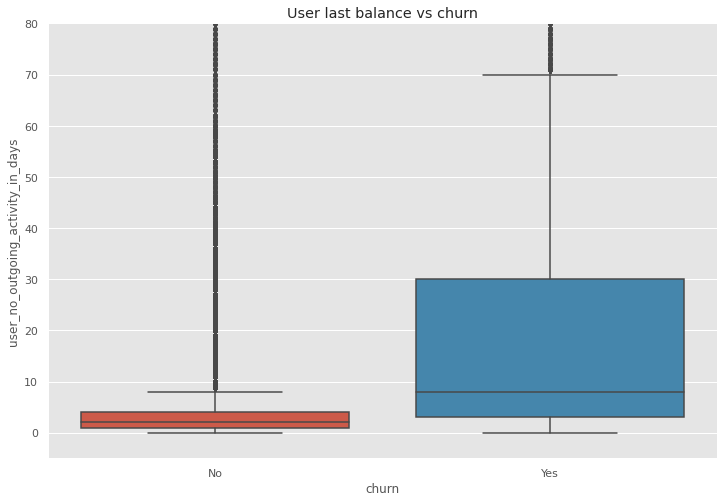

In [24]:
f, ax = plt.subplots()
sns.boxplot(dropped.churn,dropped.user_no_outgoing_activity_in_days, ax=ax)
ax.set(ylim=(-5,80), title='User last balance vs churn')
plt.show()

* The churners stay inactive more than the non-churners.

In [25]:
cat = dropped[['user_has_outgoing_calls', 'user_has_outgoing_sms', 'user_use_gprs', 'user_does_reload', 'churn']]
#maping the columns
cat.user_has_outgoing_calls = cat.user_has_outgoing_calls.map({0:'No', 1:'Yes'})
cat.user_has_outgoing_sms = cat.user_has_outgoing_sms.map({0:'No', 1:'Yes'})
cat.user_use_gprs = cat.user_use_gprs.map({0:'No', 1:'Yes'})
cat.user_does_reload = cat.user_does_reload.map({0:'No', 1:'Yes'})
cat['indx'] = cat.index
#Pivot_tables
user_has_outgoing_calls = cat.pivot_table('indx',index=['user_has_outgoing_calls'],columns='churn',aggfunc='count')
user_has_outgoing_sms  = cat.pivot_table('indx',index=['user_has_outgoing_sms'],columns='churn',aggfunc='count')
user_use_gprs = cat.pivot_table('indx',index=['user_use_gprs'],columns='churn',aggfunc='count')
user_does_reload = cat.pivot_table('indx',index=['user_does_reload'],columns='churn',aggfunc='count')

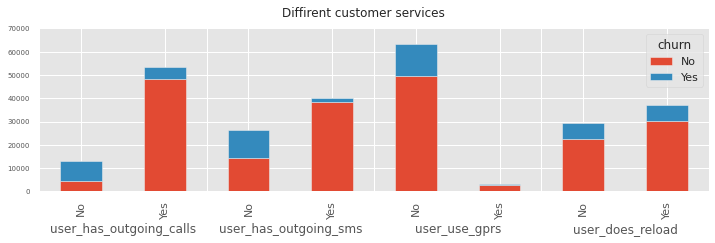

In [26]:
f, axes = plt.subplots(1,4,figsize=(12,3),sharey=True)
f.subplots_adjust(wspace=0)
f.suptitle('Diffirent customer services')
tables = [user_has_outgoing_calls, user_has_outgoing_sms, user_use_gprs, user_does_reload]
i = 0
for table in tables:
    table.plot(kind='bar', ax=axes[i], stacked=True)
    axes[i].tick_params(axis='y', labelsize=7)
    axes[i].set(ylim=(0,70000))
    if i < 3 :
        axes[i].get_legend().remove()
    i+=1
plt.show()
f.savefig("Diffirent customer services.png")

* If the user has NO outgoing calls, he is more likely to churn, which means that 'user_has_outgoing_calls' is good for separating churners from no-churners
* If the user has outgoing sms, he isn't likely to churn.
* If the user uses gprs, he isn't likely to churn
* The 'user_does_reload' variable doesn't separate well the target variable 'churn'

In [27]:
dropped.churn = dropped.churn.map({'No':0, 'Yes':1})
dropped.head()

,month,user_lifetime,user_intake,user_no_outgoing_activity_in_days,user_account_balance_last,user_spendings,user_has_outgoing_calls,user_has_outgoing_sms,user_use_gprs,user_does_reload,...,gprs_session_count,gprs_spendings,gprs_inactive_days,last_100_reloads_count,last_100_reloads_sum,last_100_calls_outgoing_to_onnet_duration,last_100_calls_outgoing_to_abroad_duration,last_100_sms_outgoing_to_abroad_count,last_100_gprs_usage,churn
0,6,1000,0,1,0.049988,0.000000,1,1,0,0,...,0,0.0,1276,4,12.007812,0.000000,0.000000,0,0.0,0
1,6,1000,0,25,28.312500,3.449219,1,0,0,0,...,0,0.0,1276,0,0.000000,11.179688,11.179688,0,0.0,0
2,6,1005,0,8,15.617188,1.969727,1,0,0,0,...,0,0.0,1276,0,0.000000,0.000000,10.453125,0,0.0,0
3,6,1013,0,11,5.621094,0.000000,1,0,0,0,...,0,0.0,1276,0,0.000000,0.000000,0.000000,0,0.0,1
4,6,1032,0,2,5.859375,0.150024,1,0,0,1,...,0,0.0,1276,1,6.000000,0.000000,0.000000,0,0.0,0


In [28]:
dropped.churn.value_counts()

0    52562
1    13907
Name: churn, dtype: int64

# RFM Analysis



RFM is a method used for analyzing customer value. It is commonly used in database marketing and direct marketing and has received particular attention in retail and professional services industries

RFM stands for the three dimensions:

    Recency – How recently did the customer purchase?
    Frequency – How often do they purchase?
    Monetary Value – How much do they spend?

   

### Creating the RFM table

In [29]:
%%time
rfm = dropped[['reloads_inactive_days','reloads_count','reloads_sum']]
rfm.columns = ['recency', 'frequency', 'monetary']
rfm.iloc[200:206].to_excel('RFM.xlsx')
rfm.iloc[200:206]


CPU times: user 16.7 ms, sys: 30 µs, total: 16.8 ms
Wall time: 18.2 ms


,recency,frequency,monetary
200,54,0,0.000000
201,3,1,12.000000
202,1276,0,0.000000
203,7,6,49.531250
204,275,1,24.015625
205,15,2,8.000000


### Clustering RFM with K-Means

The goal of the clustering is to determine and keep the clients that are most profitable and to drop the occasional clients that barely add value to the company.

#### Scaling the RFM Table

In [30]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)
rfm = pd.DataFrame(rfm_scaled, columns=rfm.columns)
rfm.iloc[200:206].to_excel('Scaled_RFM.xlsx')
rfm.iloc[200:206]

,recency,frequency,monetary
200,-0.551972,-0.695539,-0.441803
201,-0.643574,0.048419,0.238663
202,1.642887,-0.695539,-0.441803
203,-0.636390,3.768206,2.366891
204,-0.155029,0.048419,0.920015
205,-0.622021,0.792376,0.011841


#### Fitting and Applying the elbow method to determine the numbeer of clusters

We want to get the right number of cluster for K-means so we neeed to loop from 1 to 10 number of cluster and check score.
Elbow method is used to represnt that. 

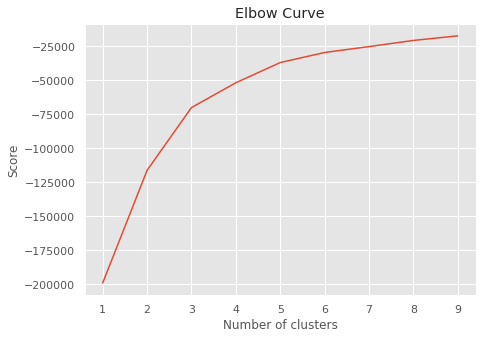

CPU times: user 14.8 s, sys: 294 ms, total: 15.1 s
Wall time: 5.2 s


In [31]:
%%time
rfm_segmentation = rfm.copy()
Nc = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(rfm_segmentation).score(rfm_segmentation) for i in range(len(kmeans))]
f, ax = plt.subplots(1, figsize=(7,5))
ax.plot(Nc,score)
ax.set_title('Elbow Curve')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Score')
f.savefig("Elbow_RFM.png")
plt.show()

the optimal k = 3

#### Fitting data in Kmeans (K = 3).

In [32]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(rfm_segmentation)

This creates a new column called cluster which has cluster number for each row respectively and adds it to the original data

In [33]:
rfm_segmentation['cluster'] = kmeans.labels_
dropped['cluster'] = kmeans.labels_
new = dropped.copy()
rfm_segmentation.reset_index()
new.head()

,month,user_lifetime,user_intake,user_no_outgoing_activity_in_days,user_account_balance_last,user_spendings,user_has_outgoing_calls,user_has_outgoing_sms,user_use_gprs,user_does_reload,...,gprs_spendings,gprs_inactive_days,last_100_reloads_count,last_100_reloads_sum,last_100_calls_outgoing_to_onnet_duration,last_100_calls_outgoing_to_abroad_duration,last_100_sms_outgoing_to_abroad_count,last_100_gprs_usage,churn,cluster
0,6,1000,0,1,0.049988,0.000000,1,1,0,0,...,0.0,1276,4,12.007812,0.000000,0.000000,0,0.0,0,0
1,6,1000,0,25,28.312500,3.449219,1,0,0,0,...,0.0,1276,0,0.000000,11.179688,11.179688,0,0.0,0,1
2,6,1005,0,8,15.617188,1.969727,1,0,0,0,...,0.0,1276,0,0.000000,0.000000,10.453125,0,0.0,0,1
3,6,1013,0,11,5.621094,0.000000,1,0,0,0,...,0.0,1276,0,0.000000,0.000000,0.000000,0,0.0,1,1
4,6,1032,0,2,5.859375,0.150024,1,0,0,1,...,0.0,1276,1,6.000000,0.000000,0.000000,0,0.0,0,0


#### Intrepreting the results

Box-Plot of the RFM analysis

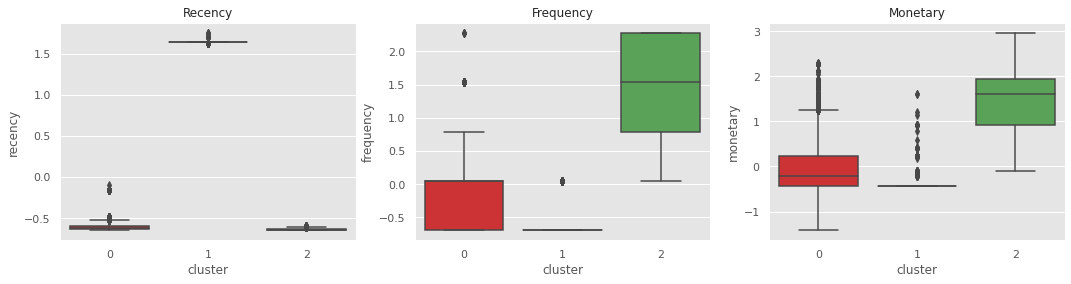

In [34]:


rfm_segmentation_plot = rfm_segmentation[(np.abs(stats.zscore(rfm_segmentation)) < 3).all(axis=1)]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,4))
#f.suptitle('Rcency, Frequency & Monetary', fontsize=14)

sns.boxplot(rfm_segmentation_plot.cluster, rfm_segmentation_plot.recency,palette="Set1", ax=ax1)
ax1.set_title('Recency', fontsize=12)

sns.boxplot(rfm_segmentation_plot.cluster,rfm_segmentation_plot.frequency,palette="Set1", ax=ax2)
ax2.set_title('Frequency', fontsize=12)

sns.boxplot(rfm_segmentation_plot.cluster,rfm_segmentation_plot.monetary,palette="Set1", ax=ax3)
ax3.set_title('Monetary', fontsize=12)

f.savefig("Box_RFM.png")
plt.show()

* In the **Recency** Box-Plot, the cluster number 1 has the highest value which means that those clients didn't do any transaction in a long time when compared to the other two clusters.
* In the **Frequency** Box-Plot, the cluster number 1 has the lowest frequency value.
* In the **Monetary** Box-Plot, the cluster number 2 has the highest value between the three which means that this group is the most profitable between the three groups.

Acording to recency, frequency and monetary box-plots, the clusters number 0 and 2 are the most profitable clusters, thus, we will eliminate cluster number 1.

#### Visualizing groups 

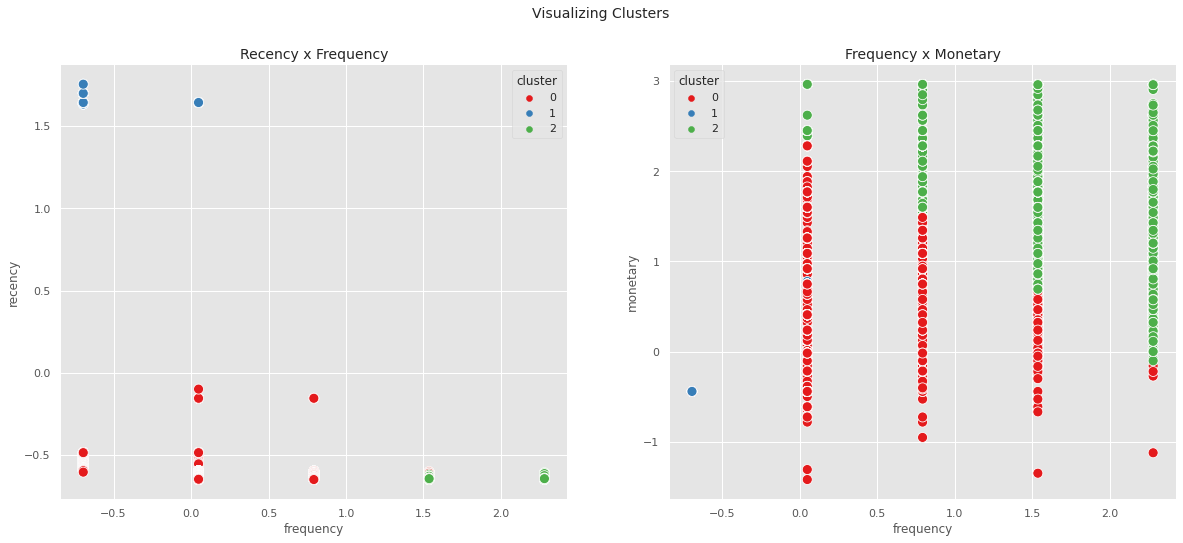

In [35]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(20,8))
f.suptitle('Visualizing Clusters', fontsize=14)

sns.scatterplot(rfm_segmentation_plot.frequency ,rfm_segmentation_plot.recency,hue = rfm_segmentation_plot.cluster,palette="Set1",s=100, ax=ax1)
ax1.set_title('Recency x Frequency', fontsize=14)

sns.scatterplot(rfm_segmentation_plot.frequency ,rfm_segmentation_plot.monetary,hue = rfm_segmentation_plot.cluster,palette="Set1",s=100, ax=ax2)
ax2.set_title('Frequency x Monetary', fontsize=14)

plt.show()

#### Comparing churn in the three clusters

churn,No,Yes
cluster,,
0,81.0,19.0
1,70.0,30.0
2,97.0,3.0


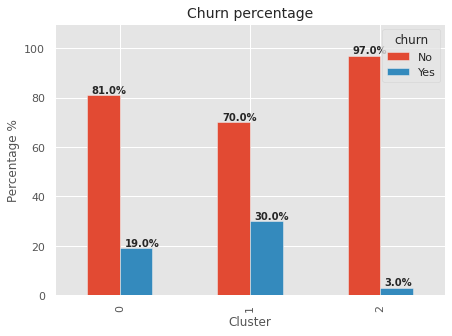

In [36]:
new_group = new.copy()
new_group.churn = new.churn.map({0:'No', 1:'Yes'})
new_group.reset_index(inplace=True)
group = new_group.pivot_table('index',index='cluster',columns='churn',aggfunc='count')
group = group.div(group.sum(axis=1), axis=0).round(2)*100
display(group)
f ,ax = plt.subplots(1, figsize=(7,5))
group.plot(kind='bar',ax=ax)
ax.set(ylim=(0, 110))
ax.set_title('Churn percentage',fontsize=14)
ax.set_ylabel('Percentage %',fontsize=12)
ax.set_xlabel('Cluster',fontsize=12)
for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width() / 2-0.09,rect.get_height()+0.9,"%.1f%%"% rect.get_height(), weight='bold',fontsize=10 )
f.savefig("Churn_RFM.png")

In [37]:
new_group.drop('index', axis=1, inplace=True)

We conclude that:
   * Churn happens more often in the cluster number 1, then number 0 and number 2 respectively,these results match with the previous results.
   * Cluster number 2 is the most profitable cluster and it includes the most loyal clients.
   * Cluster number 1 is the least profitable cluster and it includes the occasional clients.
> Thus we will eliminate the cluster number 1.

In [38]:
print('There were {} records deleted !'.format(new[new['cluster'] == 1 ].shape[0]))
new = new[new['cluster'] != 1]
new.churn = new.churn.map({0:'No', 1:'Yes'})

There were 17949 records deleted !


### Standardizing the Data 

In [39]:
new_churn = new.churn
new_X = new[new.columns.difference(['churn'])]
cols = new_X.columns
scaler = StandardScaler()
new_X = scaler.fit_transform(new_X)
new_X = pd.DataFrame(new_X, columns=cols)
new_X.head()

,calls_outgoing_count,calls_outgoing_duration,calls_outgoing_duration_max,calls_outgoing_inactive_days,calls_outgoing_spendings,calls_outgoing_spendings_max,calls_outgoing_to_abroad_count,calls_outgoing_to_abroad_duration,calls_outgoing_to_abroad_spendings,calls_outgoing_to_offnet_count,...,sms_outgoing_to_onnet_count,user_account_balance_last,user_does_reload,user_has_outgoing_calls,user_has_outgoing_sms,user_intake,user_lifetime,user_no_outgoing_activity_in_days,user_spendings,user_use_gprs
0,-0.256113,-0.564835,-0.660473,-0.402316,-0.519144,-0.567306,-0.130259,-0.140901,-0.128667,-0.397282,...,-0.215083,-0.508798,-1.808626,0.421407,0.652727,-0.240166,-0.485948,-0.280720,-0.550068,-0.246109
1,-0.326345,-0.543434,-0.609163,-0.400108,-0.506785,-0.490714,-0.130259,-0.140901,-0.128667,-0.449679,...,-0.215083,-0.216701,0.552906,0.421407,-1.532035,-0.240166,-0.480604,-0.196284,-0.540924,-0.246109
2,0.151228,0.665702,1.217966,-0.402316,0.548583,0.653171,-0.130259,-0.140901,-0.128667,-0.161496,...,-0.215083,0.117584,0.552906,0.421407,0.652727,-0.240166,-0.479436,-0.280720,0.239823,-0.246109
3,-0.522992,-0.578817,-0.731353,-0.393485,-0.519144,-0.567306,-0.130259,-0.140901,-0.128667,-0.554473,...,-0.215083,0.330097,0.552906,0.421407,0.652727,-0.240166,-0.479269,-0.280720,-0.407468,-0.246109
4,4.912913,2.895894,1.144461,-0.402316,2.194260,0.607303,-0.130259,-0.140901,-0.128667,2.825128,...,-0.215083,-0.478119,0.552906,0.421407,0.652727,-0.240166,-0.565933,-0.280720,2.245737,-0.246109


In [40]:
new_X.sample(5, axis=1).sample(5, axis=0).to_excel('Standardize_X.xlsx')

In [41]:
new_churn.head()

0    No
4    No
5    No
6    No
7    No
Name: churn, dtype: object

### Train-Test split

In [42]:
X_train, X_test, y_train, y_test = train_test_split( new_X, new_churn, test_size=0.2, random_state=23, stratify=new_churn)
name = []
shape = []
data = {'X_train':X_train, 'X_test':X_test, 'y_train':y_train, 'y_test':y_test}
for key, value in data.items():
    name.append(key)
    shape.append(len(value))
size = pd.DataFrame({'Data':name, 'Size':shape})
size.to_excel('Size.xlsx')
size

,Data,Size
0,X_train,38816
1,X_test,9704
2,y_train,38816
3,y_test,9704


## Dealing with calss imbalance

Imbalanced classification involves developing predictive models on classification datasets that have a severe class imbalance.

The challenge of working with imbalanced datasets is that most machine learning techniques will ignore, and in turn have poor performance on, the minority class, although typically it is performance on the minority class that is most important.

One approach to addressing imbalanced datasets is to oversample the minority class. The simplest approach involves duplicating examples in the minority class, although these examples don’t add any new information to the model. Instead, new examples can be synthesized from the existing examples. This is a type of data augmentation for the minority class and is referred to as the Synthetic Minority Oversampling Technique, or SMOTE for short.

### Checking for Class Imbalances

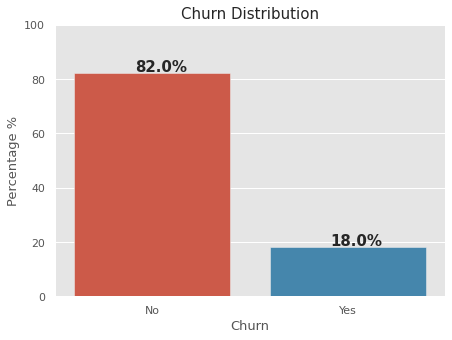

In [43]:
pourc = pd.DataFrame(y_train).value_counts()/len(y_train)*100
pourc = pd.DataFrame(pourc, columns=['pourcentage']).round().reset_index()
#pourc.churn = pourc.churn.map({0:'No', 1:'Yes'})
f,ax = plt.subplots(1, figsize=(7,5))
ax = sns.barplot(data = pourc, x='churn', y='pourcentage', ci=None ,orient='v' )
ax.set(ylim=(0, 100))
ax.set_title("Churn Distribution", fontsize=15)
ax.set_xlabel ("Churn",fontsize=13)
ax.set_ylabel ("Percentage %",fontsize=13)
for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width() / 2-0.09,rect.get_height()+0.9,"%.1f%%"% rect.get_height(), weight='bold',fontsize=15 )
f.savefig("Churn_imbalance.png")

There is a clear imbalance in the target variable, we will have to rectify this imbalance with resampling techniques

### Resampling

#### SMOTE

SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space.

**NOTE** : As mentioned in the paper, it is believed that SMOTE performs better when combined with undersampling of the majority class, such as random undersampling.

#### 1. Over-Sampling (SMOTE)

In [44]:
smote = SMOTE(sampling_strategy=0.6, random_state=23)
X_sm, y_sm = smote.fit_resample(X_train,y_train)
y_sm.shape


(51200,)

#### 2. Under-Sampling

In [45]:
under = RandomUnderSampler(random_state=23)

X, y = under.fit_resample(X_sm, y_sm)

In [46]:
print('y_train = {}, y_sm = {}, y = {} '.format(y_train.shape[0],y_sm.shape[0],y.shape[0]))

y_train = 38816, y_sm = 51200, y = 38400 


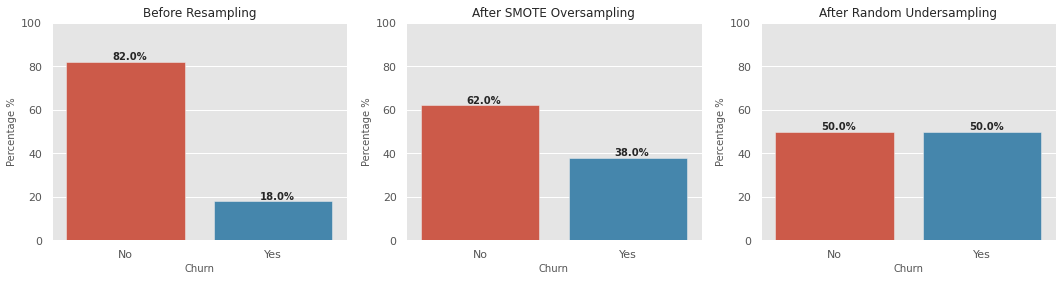

In [47]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,4))
#f.suptitle('Rcency, Frequency and Monetary Box-Plots', fontsize=18)

pourc = new[['churn']].value_counts()/len(new)*100
pourc = pd.DataFrame(pourc, columns=['pourcentage']).round().reset_index()
#pourc.churn = pourc.churn.map({0:'No', 1:'Yes'})
sns.barplot(data = pourc, x='churn', y='pourcentage', ci=None ,orient='v' ,ax=ax1)
ax1.set(ylim=(0, 100))
ax1.set_title("Before Resampling", fontsize=12)
ax1.set_xlabel ("Churn",fontsize=10)
ax1.set_ylabel ("Percentage %",fontsize=10)
for rect in ax1.patches:
    ax1.text (rect.get_x() + rect.get_width() / 2-0.09,rect.get_height()+0.9,"%.1f%%"% rect.get_height(), weight='bold',fontsize=10 )

pourc2 = y_sm.value_counts()/len(y_sm)*100
pourc2 = pd.DataFrame(pourc2).round().reset_index()
#pourc2['index'] = pourc2['index'].map({0:'No', 1:'Yes'})
sns.barplot(data = pourc2, y='churn', x='index', ci=None ,orient='v' ,ax=ax2)
ax2.set(ylim=(0, 100))
ax2.set_title("After SMOTE Oversampling", fontsize=12)
ax2.set_xlabel ("Churn",fontsize=10)
ax2.set_ylabel ("Percentage %",fontsize=10)
for rect in ax2.patches:
    ax2.text (rect.get_x() + rect.get_width() / 2-0.09,rect.get_height()+0.9,"%.1f%%"% rect.get_height(), weight='bold',fontsize=10 )

pourc3 = y.value_counts()/len(y)*100
pourc3 = pd.DataFrame(pourc3).round().reset_index()
#pourc3['index'] = pourc3['index'].map({0:'No', 1:'Yes'})
sns.barplot(data = pourc3, y='churn', x='index', ci=None ,orient='v',ax=ax3 )
ax3.set(ylim=(0, 100))
ax3.set_title("After Random Undersampling", fontsize=12)
ax3.set_xticklabels(['No','Yes'])
ax3.set_xlabel ("Churn",fontsize=10)
ax3.set_ylabel ("Percentage %",fontsize=10)
for rect in ax3.patches:
    ax3.text (rect.get_x() + rect.get_width() / 2-0.09,rect.get_height()+0.9,"%.1f%%"% rect.get_height(), weight='bold',fontsize=10 )

f.savefig("Resampling_imbalance.png")    
plt.show()

In [48]:
y = y.map({'No':0, 'Yes':1})
y_test = y_test.map({'No':0, 'Yes':1})

## Feature Selection 

Feature selection is the process of identifying a subset of important features/attributes (such as a column in tabular data) that are most relevant to the modeling and business objectives of the problem. It essentially aids in the extraction of the most meaningful inputs from the data.

### Recursive feature elimination with cross validation and random forest classification (RFECV)

Basically, it uses one of the classification methods (random forest in our example), assign weights to each of features. Whose absolute weights are the smallest are pruned from the current set features, in contrast with RFF, we will not only find best features but we also find how many features do we need for best accuracy.

In [49]:
%%time

cv = KFold(n_splits=5, shuffle=True, random_state=23)
clf = RandomForestClassifier(n_jobs=-1) 
rfecv = RFECV(estimator=clf, step=1, cv=cv,scoring='recall', n_jobs=-1)   #5-fold cross-validation
rfecv = rfecv.fit(X, y)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X.columns[rfecv.support_])

Optimal number of features : 27
Best features : Index(['calls_outgoing_count', 'calls_outgoing_duration',
       'calls_outgoing_duration_max', 'calls_outgoing_inactive_days',
       'calls_outgoing_spendings', 'calls_outgoing_spendings_max',
       'calls_outgoing_to_offnet_count', 'calls_outgoing_to_offnet_spendings',
       'gprs_inactive_days', 'last_100_reloads_count', 'last_100_reloads_sum',
       'month', 'reloads_count', 'reloads_inactive_days', 'reloads_sum',
       'sms_incoming_count', 'sms_incoming_from_abroad_count',
       'sms_outgoing_count', 'sms_outgoing_inactive_days',
       'sms_outgoing_spendings', 'sms_outgoing_spendings_max',
       'sms_outgoing_to_onnet_count', 'user_account_balance_last',
       'user_intake', 'user_lifetime', 'user_no_outgoing_activity_in_days',
       'user_spendings'],
      dtype='object')
CPU times: user 4min 43s, sys: 940 ms, total: 4min 44s
Wall time: 11min 29s


**30** is the ideal number of features which was determined by the RFECV algorithm

In [50]:
keep_cols = X.columns[rfecv.support_]
keep_cols

Index(['calls_outgoing_count', 'calls_outgoing_duration',
       'calls_outgoing_duration_max', 'calls_outgoing_inactive_days',
       'calls_outgoing_spendings', 'calls_outgoing_spendings_max',
       'calls_outgoing_to_offnet_count', 'calls_outgoing_to_offnet_spendings',
       'gprs_inactive_days', 'last_100_reloads_count', 'last_100_reloads_sum',
       'month', 'reloads_count', 'reloads_inactive_days', 'reloads_sum',
       'sms_incoming_count', 'sms_incoming_from_abroad_count',
       'sms_outgoing_count', 'sms_outgoing_inactive_days',
       'sms_outgoing_spendings', 'sms_outgoing_spendings_max',
       'sms_outgoing_to_onnet_count', 'user_account_balance_last',
       'user_intake', 'user_lifetime', 'user_no_outgoing_activity_in_days',
       'user_spendings'],
      dtype='object')

In [51]:
X = X[keep_cols]
X_test = X_test[keep_cols]

# Model Selection

### Choosing the best model by Cross-Validation

In [52]:
%%time
#Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    #gaussian_process.GaussianProcessClassifier(copy_X_train=False),
    
    #GLM
    linear_model.LogisticRegressionCV(solver='liblinear'),
    #linear_model.PassiveAggressiveClassifier(),
    #linear_model.RidgeClassifierCV(),
    #linear_model.SGDClassifier(),
    #linear_model.Perceptron(),
    
    #Navies Bayes
    #naive_bayes.BernoulliNB(),
    #naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    #neighbors.KNeighborsClassifier(),
    
    #SVM
    #svm.SVC(probability=True),
    #svm.NuSVC(probability=True),
    #svm.LinearSVC(),
    
    #Trees    
    #tree.DecisionTreeClassifier(),
    tree.DecisionTreeClassifier(),
    
    #Discriminant Analysis
    #discriminant_analysis.LinearDiscriminantAnalysis(),
    #discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier(),
    
    #LightGBM
    LGBMClassifier(n_jobs=-1),
    ]


#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['Name','Accuracy','Recall', 'Precision', 'F1_score']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
#MLA_predict = y.copy()

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'Name'] = MLA_name
    #MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    #scoring = ['accuracy','precision', 'recall', 'f1_weighted']
    scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}
    
    cv_results = model_selection.cross_validate(alg, X, y,cv  = cv_split, scoring=scoring, n_jobs=-1)
    MLA_compare.loc[row_index, 'Fit Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'Accuracy'] = cv_results['test_accuracy'].mean()
    #print(cv_results['test_accuracy'].mean())
    MLA_compare.loc[row_index, 'Recall'] = cv_results['test_recall'].mean()
    MLA_compare.loc[row_index, 'Recall_STD'] = cv_results['test_recall'].std()
    MLA_compare.loc[row_index, 'Precision'] = cv_results['test_precision'].mean()
    MLA_compare.loc[row_index, 'F1_score'] = cv_results['test_f1_score'].mean()
    #MLA_compare.loc[row_index, 'Parameters'] = str(alg.get_params())
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    #MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_accuracy'].std()*3   #let's know the worst that can happen!
    print(cv_results['fit_time'].mean(), '==>  ',MLA_name, 'is done!')

    

    #save MLA predictions - see section 6 for usage
    #alg.fit(X, y)
    #y_predict = alg.predict(X_test)
    #print(classification_report(y_test, y_predict))
    #print('-'*25)
    
    row_index+=1
    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['Recall'], ascending = False, inplace = True)
MLA_compare
#MLA_predict

2.59715576171875 ==>   AdaBoostClassifier is done!
3.453260660171509 ==>   BaggingClassifier is done!
4.108889079093933 ==>   ExtraTreesClassifier is done!
10.431561374664307 ==>   GradientBoostingClassifier is done!
7.637122750282288 ==>   RandomForestClassifier is done!
10.061634421348572 ==>   LogisticRegressionCV is done!
0.5143014430999756 ==>   DecisionTreeClassifier is done!
111.3980390071869 ==>   XGBClassifier is done!
236.69014797210693 ==>   LGBMClassifier is done!
CPU times: user 899 ms, sys: 164 ms, total: 1.06 s
Wall time: 17min 15s


,Name,Accuracy,Recall,Precision,F1_score,Fit Time,Recall_STD
7,XGBClassifier,0.921181,0.916141,0.925782,0.920926,111.398039,0.003582
8,LGBMClassifier,0.919948,0.913418,0.925814,0.919568,236.690148,0.003624
4,RandomForestClassifier,0.912413,0.896945,0.925927,0.911194,7.637123,0.004768
3,GradientBoostingClassifier,0.907066,0.894341,0.918071,0.906045,10.431561,0.003463
6,DecisionTreeClassifier,0.872604,0.893164,0.858295,0.875376,0.514301,0.005133
2,ExtraTreesClassifier,0.910833,0.892289,0.92701,0.909308,4.108889,0.005214
1,BaggingClassifier,0.906623,0.888898,0.921939,0.905111,3.453261,0.004316
0,AdaBoostClassifier,0.874453,0.843717,0.899478,0.870693,2.597156,0.004283
5,LogisticRegressionCV,0.852109,0.786007,0.906372,0.841903,10.061634,0.004224


In [53]:
MLA_compare.sort_values(by = ['F1_score'], ascending = False, inplace = True)
MLA_compare.to_excel('MLA_compare.xlsx')
MLA_compare

,Name,Accuracy,Recall,Precision,F1_score,Fit Time,Recall_STD
7,XGBClassifier,0.921181,0.916141,0.925782,0.920926,111.398039,0.003582
8,LGBMClassifier,0.919948,0.913418,0.925814,0.919568,236.690148,0.003624
4,RandomForestClassifier,0.912413,0.896945,0.925927,0.911194,7.637123,0.004768
2,ExtraTreesClassifier,0.910833,0.892289,0.92701,0.909308,4.108889,0.005214
3,GradientBoostingClassifier,0.907066,0.894341,0.918071,0.906045,10.431561,0.003463
1,BaggingClassifier,0.906623,0.888898,0.921939,0.905111,3.453261,0.004316
6,DecisionTreeClassifier,0.872604,0.893164,0.858295,0.875376,0.514301,0.005133
0,AdaBoostClassifier,0.874453,0.843717,0.899478,0.870693,2.597156,0.004283
5,LogisticRegressionCV,0.852109,0.786007,0.906372,0.841903,10.061634,0.004224


##### The best model is an XGBoost model.
##### **Note**: we can see that Ensemble models preform way better than classical models

#### Comparing top models on test data using confusion matrix

In [54]:
%%time
#X_train = ch66_X_train[].copy()
#y_train = ch66_y_train.copy()
#X_test = ch66_X_test[ch66_cols].copy()
#y_test = ch66_y_test.copy()
kfolds = sklearn.model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=23)
my_scorer = make_scorer(f1_score)
model = LGBMClassifier()
#knn = model.fit(ch66_X_train[ch66_cols],ch66_y_train)
model_selection.cross_val_score(model, X, y, cv=kfolds, scoring=my_scorer, n_jobs=-1)

CPU times: user 35.4 ms, sys: 24.1 ms, total: 59.5 ms
Wall time: 2min 35s


array([0.9207952 , 0.92130788, 0.91779315])

In [55]:
fit = model.fit(X, y)
y_predict = fit.predict(X_test)
f1_score(y_test,y_predict)

0.755198225672304

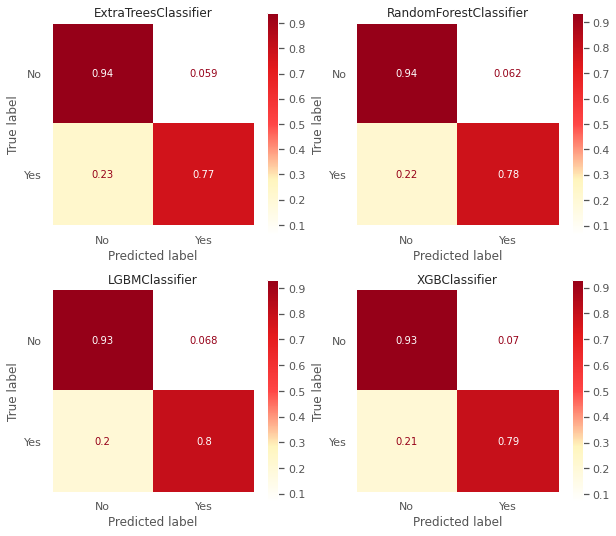

CPU times: user 34.9 s, sys: 177 ms, total: 35.1 s
Wall time: 21.8 s


In [56]:
%%time
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,9))
cmap = LinearSegmentedColormap.from_list("", ['#FFFFFF',"#FFF5BD","#FF4646",'#E41A1C',"#960018"])

models = {ax1: ensemble.ExtraTreesClassifier(),
          ax2: ensemble.RandomForestClassifier(),
          ax3 : LGBMClassifier(n_jobs=-1),
          ax4 : XGBClassifier(n_jobs=-1, verbosity=0)
         }
for ax, model in models.items():
    ax.grid(False)
    mod = model.fit(X,y)
    #y_pred = pd.Series(mod.predict(X_test)).map({0:'No', 1:'Yes'}).to_numpy()
    plot_confusion_matrix(mod, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap=cmap,
                         display_labels=['No', 'Yes'],
                         normalize='true')
    ax.set_title(str(model.__class__.__name__), fontsize=12)
f.savefig("ML_Confusion_matrices.png")     
plt.show()


As expected, the previous results are confirmed, thus, we will be using XGBoost model.

### Hyperparameter Tuning 

> Acquiring a new custommer costs **5 times** than kepping an existing one
##### The goal here is to improve the model in in the 'Recall' score in order to detect the maximum number of churners.

In [57]:
%%time
#import cudf

# Created the Xgboost specific DMatrix data format from the numpy array to optimise memory consumption
dtrain = xgb.DMatrix(X, label=y)
dvalid = xgb.DMatrix(X_test, label=y_test)

def objective(trial):
    
# params specifies the XGBoost hyperparameters to be tuned
    param = {
        #"silent": 1,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "booster": trial.suggest_categorical("booster", ["gbtree",
                                                         #"gblinear",
                                                         #"dart"
                                                        ]),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0)
        param["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    #if param["booster"] == "dart":
        #param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        #param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        #param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
        #param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)
    
    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
# trials will be evaluated based on their accuracy on the test set
    recall = sklearn.metrics.recall_score(y_test, pred_labels)
    return recall

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize')
study.optimize(objective,n_trials=500) 
#You can increase n_trials parameter

print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

Best trial: score 0.8333333333333334, params {'booster': 'gbtree', 'lambda': 0.0008187975100879099, 'alpha': 2.1659905693531115e-05, 'max_depth': 4, 'eta': 0.00010333455031654794, 'gamma': 1.3913982035793394e-08, 'grow_policy': 'depthwise'}
CPU times: user 8min 36s, sys: 528 ms, total: 8min 37s
Wall time: 2min 17s


### From previous tests, the best params are :

In [58]:
best = study.best_trial.params

# Model Validation

#### Fitting the best parameters model

In [59]:
%time 
#best_params['objective'] = 'binary:logistic'
# Fit the XGBoost classifier with optimal hyperparameters
XGB = XGBClassifier(**best,
                    verbosity = 0,
                    n_jobs=-1)
XGB.fit(X, y)  #Used the whole training data

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


XGBClassifier(alpha=2.1659905693531115e-05, base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              eta=0.00010333455031654794, gamma=1.3913982035793394e-08,
              gpu_id=-1, grow_policy='depthwise', importance_type='gain',
              interaction_constraints='', lambda=0.0008187975100879099,
              learning_rate=0.000103334547, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=2.16599055e-05, reg_lambda=0.000818797504,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=0)

#### Inspecting the classification report

In [60]:
y_predict = XGB.predict(X_test)
y_true = pd.Series(y_test).map({0:'No', 1:'Yes'}).to_numpy()
y_pred = pd.Series(y_predict).map({0:'No', 1:'Yes'}).to_numpy()
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

          No       0.96      0.90      0.93      8000
         Yes       0.64      0.83      0.72      1704

    accuracy                           0.89      9704
   macro avg       0.80      0.87      0.83      9704
weighted avg       0.90      0.89      0.89      9704



#### Confusion Matrix

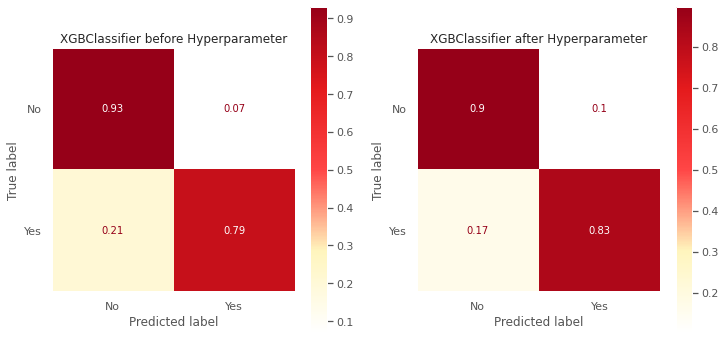

CPU times: user 23.5 s, sys: 38.9 ms, total: 23.6 s
Wall time: 6.31 s


In [61]:
%%time

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
#f.suptitle('Hyperparamter results comparison', fontsize=18)

models = {ax1: XGBClassifier(verbosity = 0, n_jobs=-1),
          ax2: XGB
         }
for ax, model in models.items():
    ax.grid(False)
    mod = model.fit(X,y)
    #y_pred = pd.Series(mod.predict(X_test)).map({0:'No', 1:'Yes'}).to_numpy()
    plot_confusion_matrix(mod, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap=cmap,
                         display_labels=['No', 'Yes'],
                         normalize='true')
    ax1.set_title('XGBClassifier before Hyperparameter', fontsize=12)
    ax2.set_title('XGBClassifier after Hyperparameter', fontsize=12)

f.savefig("Hyperparameter.png")
plt.show()


The new model has improved in the Recall score of the positive class 'Yes', **Although** it has lost some Accuarcy and Precision which is understandable and does not affect much the study.

The rate of churned customers captured by the model is satisfying

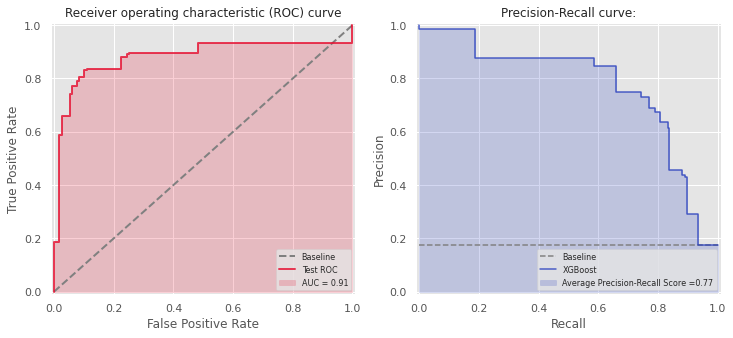

In [62]:
y_prob = XGB.predict_proba(X_test)
    
fpr_t, tpr_t, t_t = roc_curve(y_test, y_prob[:, 1])

average_precision = average_precision_score(y_test, y_prob[:, 1])
precision, recall, _ = precision_recall_curve(y_test, y_prob[:, 1])
roc_auc = auc(fpr_t, tpr_t)
no_skill = len(y_test[y_test==1]) / len(y_test)

f, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))
#f.suptitle('ROC and Precision-Recall Curves', fontsize=15)

#ROC
ax1.plot([0, 1], [0, 1], linestyle = '--', lw = 2,label='Baseline', color = 'grey', alpha= 1)
ax1.step(fpr_t, tpr_t, lw=2, alpha=0.8,where='post', label='Test ROC ', color = '#E60F30')
ax1.fill_between(fpr_t, tpr_t, step='post', alpha=0.2,color='#E60F30', label='AUC = %0.2f' % (roc_auc))
ax1.set_xlim([-0.01, 1.01])
ax1.set_ylim([-0.01, 1.01])
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')
ax1.legend(loc="lower right",prop={'size': 8})
ax1.set_title('Receiver operating characteristic (ROC) curve', fontsize=12)

#Precision-Recall
ax2.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Baseline', alpha=1, color = 'grey')
ax2.step(recall, precision, color='#243BBD', alpha=0.8,where='post', label='XGBoost')
ax2.fill_between(recall, precision, step='post', alpha=0.2,color='#243BBD', label='Average Precision-Recall Score ={0:0.2f}'.format(average_precision))
ax2.set_ylabel('Precision')
ax2.set_xlabel('Recall')
ax2.set_xlim([-0.01, 1.01])
ax2.set_ylim([-0.01, 1.01])
ax2.set_title('Precision-Recall curve:', fontsize=12)
ax2.legend(loc="lower right",prop={'size': 8})

f.savefig("Roc_Recall-Precision.png")    
plt.show()

#### Feature Importance 

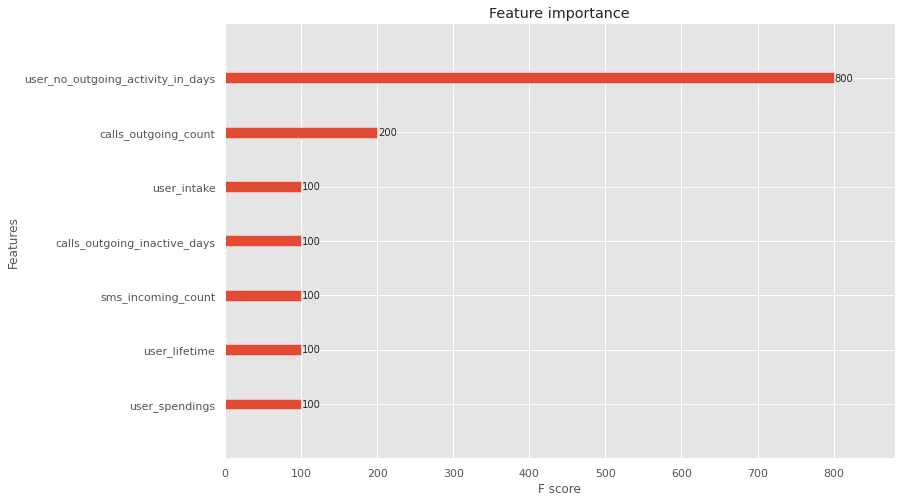

In [63]:
XGB = XGBClassifier(**best).fit(X,y)
plot_importance(XGB,max_num_features=10)
plt.show()

### SHAP Values

In [64]:
explainer = shap.TreeExplainer(XGB)
shap_values = explainer(X)

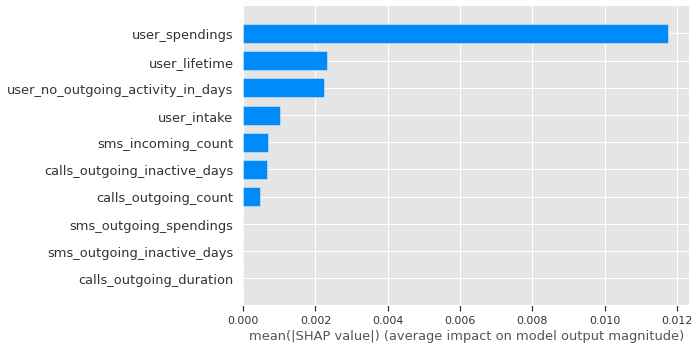

<Figure size 864x576 with 0 Axes>

In [65]:
shap.summary_plot(shap_values, X, plot_type="bar", max_display=10)
plt.savefig("SHAP_bar.png")

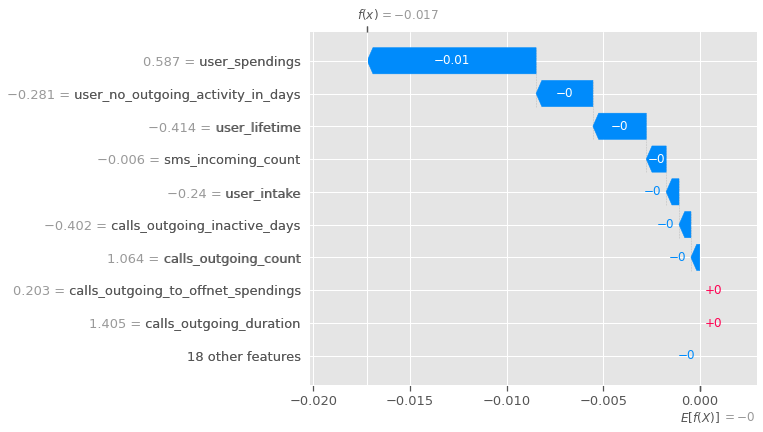

In [66]:

#shap.summary_plot(shap_values, X_test, plot_type="bar")
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[100])

In [67]:
shap.initjs()
shap.plots.force(shap_values[1420])


In [68]:
shap.plots.force(shap_values[6311])

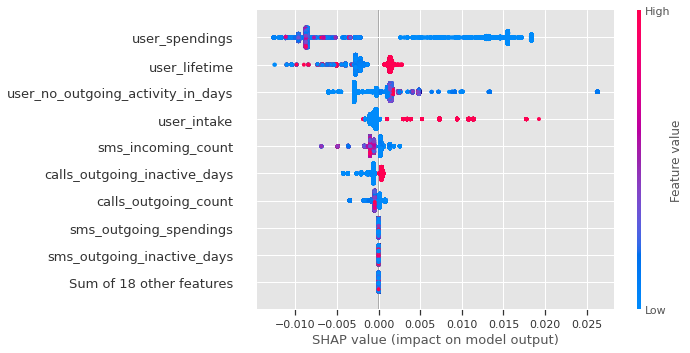

<Figure size 864x576 with 0 Axes>

In [69]:
shap.plots.beeswarm(shap_values)
plt.savefig("SHAP_summary.png")

In [70]:
XGB.predict(X_test.iloc[100:101,:])

array([1])

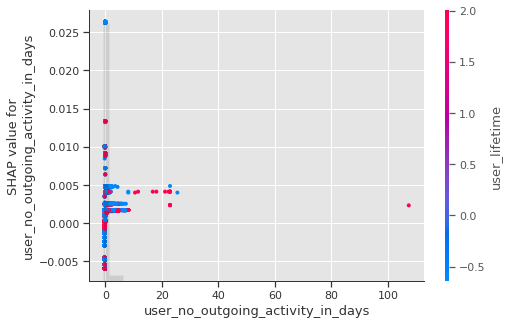

In [71]:
shap.plots.scatter(shap_values[:,"user_no_outgoing_activity_in_days"], color=shap_values)

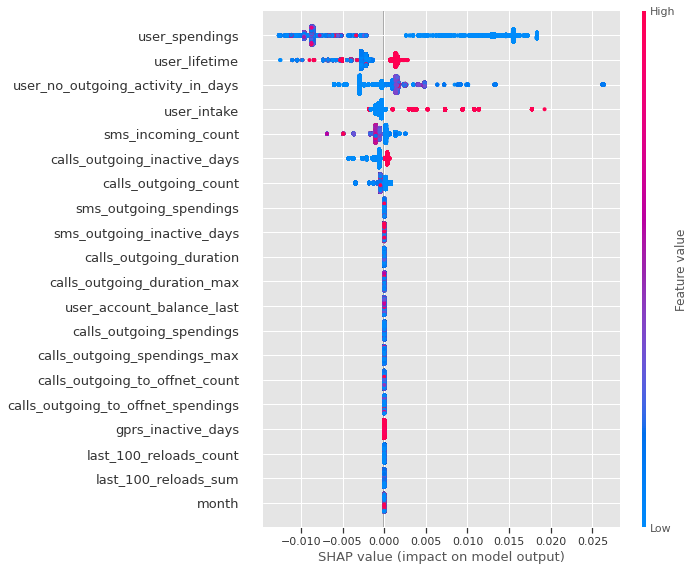

In [72]:

shap.summary_plot(shap_values, X)


# Conclusion

This study concluded that ensemble learning algorithms, such as XGBoost, performed the best in predicting customer churn with an accuracy of 90%. The XGBClassifier model is capable of handling both classes effectively in identifying churners and non-churners. The most relevant feature in predicting customer churn is `user_spendings`. 

SHAP values were used to interpret the model and examine feature influence, providing a better understanding of the model's behavior. 

Additionally, we were able to examine and determine the influence of each feature on churn prediction both globally on the whole dataset and individually on two random customers.